In [2]:
%matplotlib inline
import numpy as np
from base.classifiers import OnevsallContinuous
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mplcolors
import pandas as pd
import seaborn as sns
import numpy

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
%aimport base.plotting

In [5]:
o_clf_3 = OnevsallContinuous.load('../results/classification/newmFC_kmeans_coact_m100_pca_3_GNB_t0.05_cog_topics_60/classifier.pkl')
o_clf_9 = OnevsallContinuous.load('../results/classification/newmFC_kmeans_coact_m100_pca_9_GNB_t0.05_cog_topics_60/classifier.pkl')

In [6]:
from base.plotting import nine_colors

In [7]:
SMA = [3, 6]
dACC = [9, 5, 1, 7]
mPFC = [2, 4, 8]

all_rois = SMA + dACC + mPFC
all_mask = [SMA, dACC, mPFC]

base/plotting.py:67: FutureWarning: order is deprecated, use sort_values(...)
  labels.extend(data.iloc[:, i].order(ascending=False) \


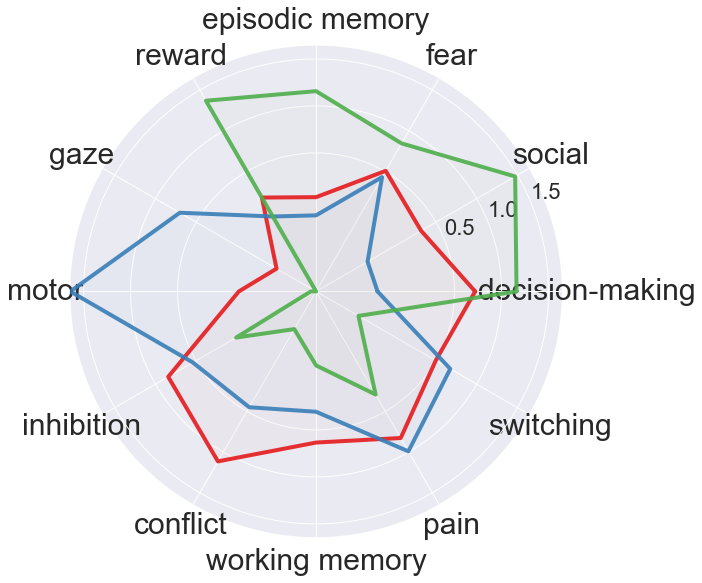

In [8]:
all_labels = base.plotting.plot_clf_polar(o_clf_3, n_top=5, return_labels=True)
all_labels = all_labels[-9:] +  all_labels[:-9] 


In [9]:
all_labels = ['fear', 
 'reward',
 'gaze',
 'motor',
 'inhibition',
 'working memory',
 'conflict',
 'switching',
'pain',
 'decision-making',
 'social',
 'episodic memory']

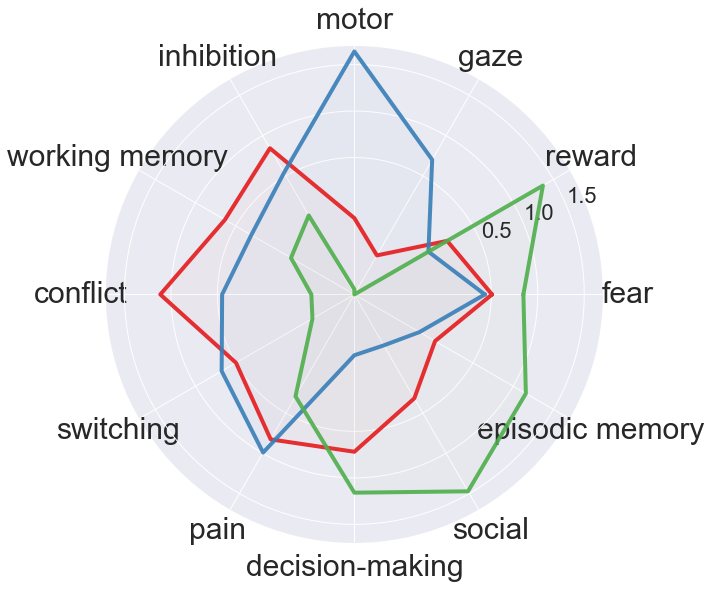

In [10]:
base.plotting.plot_clf_polar(o_clf_3, n_top=4, labels=all_labels, max_val=1.7)
ax = plt.gca()
plt.savefig('../reports/MFC/mFC_3_logodds.pdf', bbox_inches='tight')

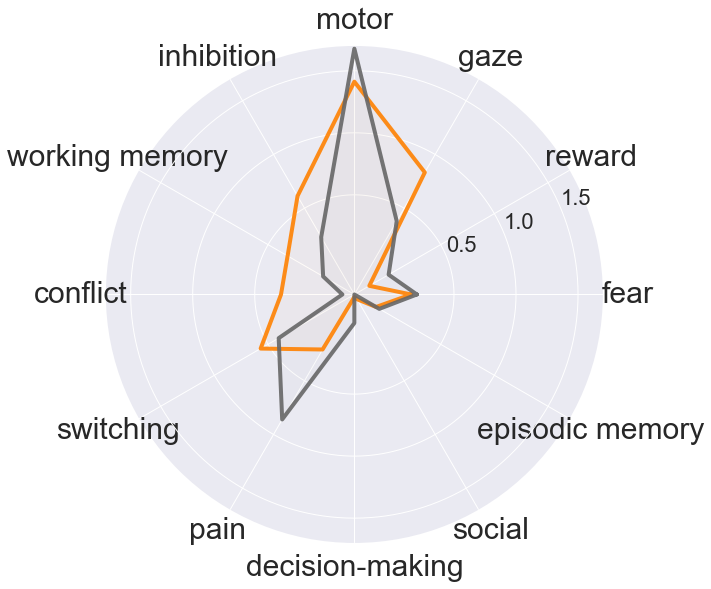

In [11]:
base.plotting.plot_clf_polar(o_clf_9, n_top=4, mask=SMA, cmap=nine_colors, labels=all_labels, max_val=1.7)
plt.savefig('../reports/MFC/mFC_polar_SMA_logodds.pdf', bbox_inches='tight')

In [12]:
# plot_clf_polar(o_clf_9, n_top=8, mask=SMA, cmap=nine_colors, selection='std')


In [13]:
nine_colors = [(0.8941176533699036, 0.10196078568696976, 0.10980392247438431),
 (0.6584544609574711, 0.34122261685483596, 0.1707958535236471),
 (1.0, 0.5059131104572147, 0.0031372549487095253),
 (0.2160246080043269, 0.49487120380588606, 0.7198769869757634),
 (0.30426760128900115, 0.6832910605505401, 0.29293349969620797),
 (0.400002384185791, 0.4000002384185791, 0.4000000238418579),
 (0.6008304736193488, 0.30814303335021526, 0.83955229815315),
 (0.9985082685246187, 0.6084660039228551, 0.8492888871361229),
 (0.9931564786854912, 0.9870049982678657, 0.19915417450315812)]

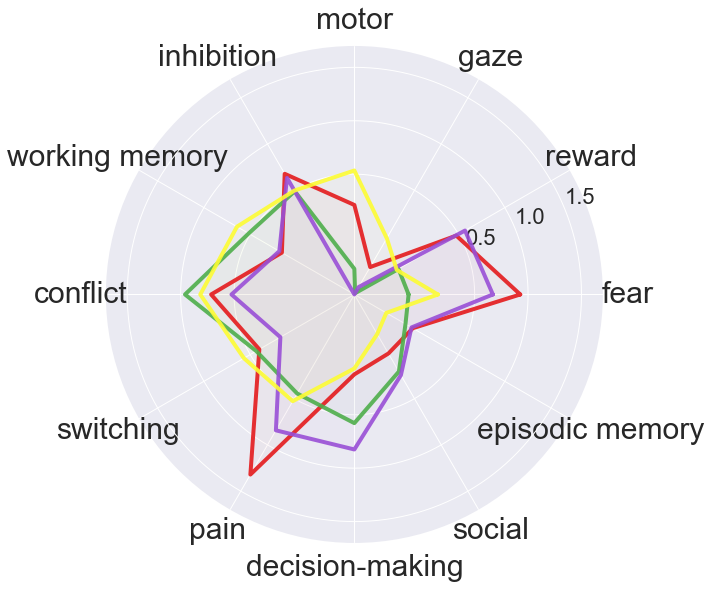

In [14]:
base.plotting.plot_clf_polar(o_clf_9, n_top=3, mask=dACC, cmap=nine_colors, labels=all_labels, max_val=1.7)
plt.savefig('../reports/MFC/mFC_polar_dACC_logodds.pdf', bbox_inches='tight')

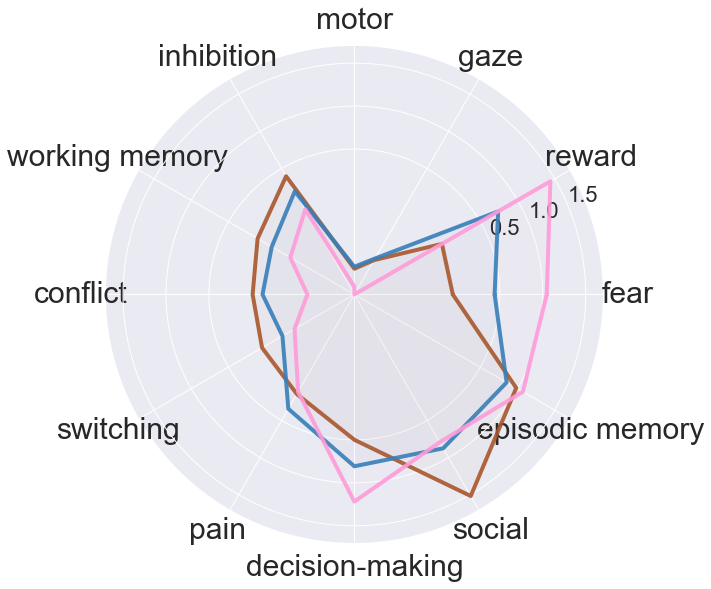

In [15]:
base.plotting.plot_clf_polar(o_clf_9, n_top=9, mask=mPFC, cmap=nine_colors, labels=all_labels, max_val=1.7)
plt.savefig('../reports/MFC/mFC_polar_mPFC_logodds.pdf', bbox_inches='tight')

In [16]:
## Selecting same topics for all regions

In [17]:
def plot_clf_polar_all(o_clf, mask, cmap=None, key='nickname', n_topics=60, n_top=3, 
                       selection='top', metric='correlation', label_size=26, threshold=None,
                      max_val = None):

    ## Set up topic nicknames
    word_keys = pd.read_csv("../data/unprocessed/abstract_topics_filtered/topic_sets/topic_keys" + str(n_topics) + "-july_cognitive.csv")
    word_keys['top_2'] = word_keys.words.apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])
    word_keys['top_3'] = word_keys.words.apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + ' ' + x.split(' ')[2])
    word_keys['top_words'] = word_keys.words.apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1] + ' ' + x.split(' ')[2])
    word_keys['topic_name'] = "topic" + word_keys['topic'].astype('str')

    
    o_fi = pd.DataFrame(o_clf.odds_ratio)

    # Melt feature importances, and add top_words for each feeature
    o_fi['region'] = range(1, o_fi.shape[0] + 1)
    o_fis_melt = pd.melt(o_fi, var_name='topic_order', value_name='importance', id_vars=['region'])

    word_keys = pd.merge(pd.DataFrame(np.array([range(0, o_clf.feature_importances.shape[1]), o_clf.feature_names]).T, columns=['topic_order', 'topic_name']), word_keys)
    word_keys.topic_order = word_keys.topic_order.astype('int')

    o_fis_melt= pd.merge(o_fis_melt, word_keys)
    o_fis_melt['abs_imp'] = np.abs(o_fis_melt['importance'])
        
    data = pd.pivot_table(o_fis_melt, values='importance', index=[key], columns=['region'])
        
    n_panels = len(mask)

    if selection == 'top':
        labels = []
        for i in range(n_panels):
            labels.extend(data.iloc[:, i].order(ascending=False) \
                .index[:n_top])
        labels = np.unique(labels)
    elif selection == 'std':
        labels = data.T.std().order(ascending=False).index[:n_top]

    data = data.loc[labels,:]
    
    # Use hierarchical clustering to order
    from scipy.spatial.distance import pdist
    from scipy.cluster.hierarchy import linkage, leaves_list
    dists = pdist(data, metric=metric)
    pairs = linkage(dists)
    pairs[pairs < 0] = 0
    order = leaves_list(pairs)
    data = data.iloc[order,:]
    labels = [labels[i] for i in order]


    theta = np.linspace(0.0, 2 * np.pi, len(labels), endpoint=False)
    
    ## Add first
    theta = np.concatenate([theta, [theta[0]]])
    fig, axes = plt.subplots(n_panels, 1, sharex=False, sharey=False,
                         subplot_kw=dict(polar=True))
    fig.set_size_inches((8, 8 * n_panels))

        
    
    if max_val is None:
        max_val = data.values.max()
    
    for set_i, regions in enumerate(mask):
        ax = axes[set_i]
        
        ax.set_ylim(data.values.min(), max_val)
        
        for reg in regions:
            d = data.iloc[:,reg-1].values
            d = np.concatenate([d, [d[0]]])
        
            ax.plot(theta, d, alpha=1, color='black', linewidth=5)
            ax.plot(theta, d, alpha=0.9, color=cmap[reg-1], linewidth=4)

            ax.fill(theta, d, ec='k', alpha=0.05, color=cmap[reg-1], linewidth=0)
            ax.set_xticks(theta)
            ax.set_xticklabels(labels, fontsize=label_size)
            [lab.set_fontsize(18) for lab in ax.get_yticklabels()]

    
#     if threshold is not None:
#         theta = np.linspace(0.0, 2 * np.pi, 999, endpoint=False)
#         theta = np.concatenate([theta, [theta[0]]])
#         d = np.array([threshold] * 1000)
#         ax.plot(theta, d, alpha=1, color='black', linewidth=2, linestyle='--')


    plt.tight_layout()


### Bootstrap plot

In [18]:
from sklearn.naive_bayes import GaussianNB
from base import tools
from multiprocessing import Pool
import itertools


In [19]:
from joblib import Memory
memory = Memory('../cache/',  verbose=0)

In [20]:
def bootstrap_parallel(args):
    (X, y, cla, feat_names, region), i = args
    
    ## Split into classes
    X0 = X[y == 0]
    X1 = X[y == 1]

    ## Sample with replacement from each class
    X0_boot = X0[np.random.choice(X0.shape[0], X0.shape[0])]
    X1_boot = X1[np.random.choice(X1.shape[0], X1.shape[0])]

    # Recombine
    X_boot = np.vstack([X0_boot, X1_boot])
    
    cla_fits = cla.fit(X_boot, y)
    fit_w = np.log(cla_fits.theta_[1] / cla_fits.theta_[0])
    
    results = []
    for n, lo in enumerate(fit_w):
        results.append([region + 1, i, feat_names[n], lo])
        
    return results

boot_n = 1000
pb = tools.ProgressBar(boot_n * len(o_clf_9.data), start=True)

In [21]:
pool = Pool(processes=7)

overall_boot = []
for reg, (X, y) in enumerate(o_clf_9.data):
    for result in pool.imap(bootstrap_parallel, itertools.izip(
            itertools.repeat((X, y, GaussianNB(), o_clf_3.feature_names, reg)), range(boot_n))):
        for res in result:
            overall_boot.append(res)
        pb.next()
        
overall_boot = pd.DataFrame(overall_boot, columns=['region', 'perm_n', 'topic_name', 'fi'])

[##########] 100%


In [ ]:
clf5.

In [22]:
from base.statistics import percentile

In [38]:
boot_ci = overall_boot.groupby(['region', 'topic_name'])['fi'].agg({'mean' : np.mean, 'low_ci' : percentile(2.5), 'hi_ci' : percentile(97.5)}).reset_index()

In [39]:
regions = ['SMAc', 'SMAr', 'pdMCC', 'adMCC', 'pMCC', 'aMCC', 'rACC', 'dmPFC', 'vmPFC']

In [40]:
regions = dict(zip(regions, all_rois))

In [41]:
boot_ci['region_name'] =  boot_ci.region.map({v: k for k, v in regions.items()})

In [42]:
def plot_clf_polar_ci(o_fis_melt, cmap=None, mask=None, key='nickname', region_col='region_name', error_bars=None, **kwargs):
    import pandas as pd
    import seaborn as sns
#     import base.plotting
    
    if mask is not None:
        o_fis_melt = o_fis_melt[o_fis_melt[region_col].isin(mask)]
    
    pplot = pd.pivot_table(o_fis_melt, values='mean', index=[key], columns=[region_col])
    
    if cmap is None:
        cmap = sns.color_palette('Set1', pplot.shape[0])
        
    if mask is not None:
        cmap = [n[0] for n in sorted(zip(np.array(cmap)[np.array(mask)-1], mask), key=lambda tup: tup[1])]
        
    if error_bars is not None:
        fis_ci['yerror'] = np.mean([np.abs(fis_ci['mean'] - fis_ci['hi_ci']), np.abs(fis_ci['mean'] - fis_ci['low_ci'])])
        error_bars = pd.pivot_table(o_fis_melt, values='yerror', index=[key], columns=[region_col])
        
    return base.plotting.plot_polar(pplot, overplot=True, palette=cmap, error_bars=error_bars, **kwargs)

In [43]:
n_topics = 60
word_keys = pd.read_csv("../data/unprocessed/abstract_topics_filtered/topic_sets/topic_keys" + str(n_topics) + "-july_cognitive.csv")
word_keys['topic_name'] = "topic" + word_keys['topic'].astype('str')

In [44]:
fis_ci = pd.merge(boot_ci, word_keys)

In [45]:
fis_ci.nickname.unique()

array(['stress', 'vision-shape', 'episodic memory', 'object recognition',
       'motor', 'attention', 'gaze', 'learning', 'social', 'math',
       'language', 'reward', 'errors', 'switching', 'audition', 'emotion',
       'speech', 'reading', 'conflict', 'decision-making', 'semantic',
       'inhibition', 'LTM', 'action', 'reasoning', 'fear', 'gustation',
       'working memory', 'motion', 'pain', 'sensory', 'spatial processing',
       'repetition priming'], dtype=object)

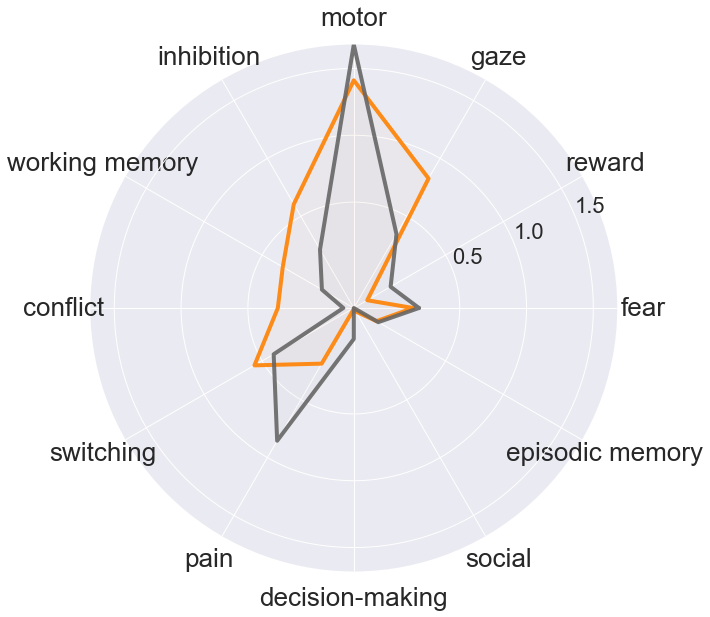

In [46]:
plot_clf_polar_ci(fis_ci, cmap=nine_colors, labels=all_labels, mask=SMA, region_col='region')

In [60]:
fis_ci.nickname.unique()

array(['stress', 'vision-shape', 'episodic memory', 'object recognition',
       'motor', 'attention', 'gaze', 'learning', 'social', 'math',
       'language', 'reward', 'errors', 'switching', 'audition', 'emotion',
       'speech', 'reading', 'conflict', 'decision-making', 'semantic',
       'inhibition', 'LTM', 'action', 'reasoning', 'fear', 'gustation',
       'working memory', 'motion', 'pain', 'sensory', 'spatial processing',
       'repetition priming'], dtype=object)

In [66]:
fis_ci['hi_ci_r'] = fis_ci.hi_ci.round(1)
fis_ci['low_ci_r'] = fis_ci.low_ci.round(1)

In [77]:
fis_ci[(fis_ci.nickname.isin(['reward', 'fear'])) & (fis_ci.region_name.isin(['rACC', 'dmPFC', 'vmPFC']))][['region_name', 'low_ci_r', 'hi_ci_r', 'nickname']]

,region_name,low_ci_r,hi_ci_r,nickname
100,rACC,-0.4,0.3,reward
102,dmPFC,0.5,1.0,reward
106,vmPFC,1.2,1.7,reward
226,rACC,-0.4,0.3,fear
228,dmPFC,0.2,0.7,fear
232,vmPFC,0.8,1.3,fear


In [48]:
plot_clf_polar_ci(fis_ci, error_bars=True, cmap=nine_colors, labels=all_labels, mask=SMA, n_top=8, region_col='region', alpha_level=0)

DataError: No numeric types to aggregate

In [ ]:
plot_clf_polar_ci(fis_ci, error_bars=True, cmap=nine_colors, labels=all_labels, mask=dACC, n_top=8, region_col='region')

In [ ]:
plot_clf_polar_ci(fis_ci, error_bars=True, cmap=nine_colors, labels=all_labels, mask=[9, 1], n_top=8, region_col='region')

In [ ]:
dACC

In [ ]:
plot_clf_polar_ci(fis_ci, error_bars=True, cmap=nine_colors, labels=all_labels, mask=[5, 7], n_top=8, region_col='region')

In [ ]:
plot_clf_polar_ci(fis_ci, error_bars=True, cmap=nine_colors, labels=all_labels, mask=[5, 1], n_top=8, region_col='region')

In [ ]:
plot_clf_polar_ci(fis_ci, error_bars=True, cmap=nine_colors, labels=all_labels, mask=mPFC, n_top=8, region_col='region')